<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Pre-sets" data-toc-modified-id="Pre-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pre-sets</a></span></li></ul></li><li><span><a href="#Data-loading-and-processing" data-toc-modified-id="Data-loading-and-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data loading and processing</a></span><ul class="toc-item"><li><span><a href="#Kawasaki-Disease" data-toc-modified-id="Kawasaki-Disease-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Kawasaki Disease</a></span><ul class="toc-item"><li><span><a href="#Full-Japanese-temporal-records" data-toc-modified-id="Full-Japanese-temporal-records-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Full Japanese temporal records</a></span></li><li><span><a href="#Tokyo-records-(2011-2018)" data-toc-modified-id="Tokyo-records-(2011-2018)-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Tokyo records (2011-2018)</a></span></li></ul></li><li><span><a href="#Shapes" data-toc-modified-id="Shapes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Shapes</a></span></li></ul></li><li><span><a href="#Generating-the-backtrajectories" data-toc-modified-id="Generating-the-backtrajectories-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating the backtrajectories</a></span></li><li><span><a href="#Trajectories-groupying-and-analysis" data-toc-modified-id="Trajectories-groupying-and-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trajectories groupying and analysis</a></span></li><li><span><a href="#Extra" data-toc-modified-id="Extra-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra</a></span></li><li><span><a href="#Comments" data-toc-modified-id="Comments-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Comments</a></span></li></ul></div>

# Full code and analysis

This notebook should serve as a guide to reproduce the analysis and figures shown in the poster and
main summary file.

The whole analysis can be performed using `Python` (<3.8) and a local installation of [HYSPLIT](https://www.ready.noaa.gov/HYSPLIT_register.php) (follow the link
for the instructions on how to get it installed). 

While the full KD registry dataset can't be shared, we will share the list of dates selected as KD Maxima
and KD Minima so that the trajectory generation can be emulated and reproduced.

## Preamble

### Imports

In [1]:
import shapely
import pysplit

import numpy as np
import pandas as pd
import plotnine as p9
import geopandas as gpd

from glob import glob
from matplotlib import rc
from itertools import product
from mizani.breaks import date_breaks
from src.utils import add_date_columns
from shapely.geometry import Point, LineString
from plotnine.animation import PlotnineAnimation
from mizani.formatters import percent_format, date_format, custom_format

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Pre-sets

In [2]:
p9.options.set_option('dpi', 200)
p9.options.set_option('figure_size', (4, 3))
p9.options.set_option('base_family', 'Bitstream Vera Serif')
p9.theme_set(p9.theme_bw() + p9.theme(axis_text=p9.element_text(size=7),
                                      axis_title=p9.element_text(size=9)))


rc('animation', html='html5')

## Data loading and processing

### Kawasaki Disease

#### Full Japanese temporal records

We have acces to a pre-processed file with the number of hospital admissions registered as
Kawasaki Disease cases for all of Japan starting from 1970 and up to 2018. For privacy reasons
we are not allowed to share this but since we will just use this to generate the general time
series for the whole period, it shouldn't be a big deal. 

We load a file and show a sample of 10 rows, with the date and the number of registered admissions:

In [3]:
kd_japan = (pd.read_csv('../data/kawasaki_disease/japan_ts.csv', index_col=0)
            .reset_index()
            .rename(columns={'index': 'date'})
            .assign(date=lambda dd: pd.to_datetime(dd.date))
)
kd_japan.sample(10).set_index('date')


kd_cases
date                
1977-11-25         6
1974-03-13         6
1970-12-29         0
2014-06-19        57
1995-02-27        14
2006-08-28        47
2016-05-15        17
2015-04-27        78
2015-04-17        61
1985-12-18        80

If we plot the full temporal series for the daily KD hospital admissions in all of Japan, the figure is the following:

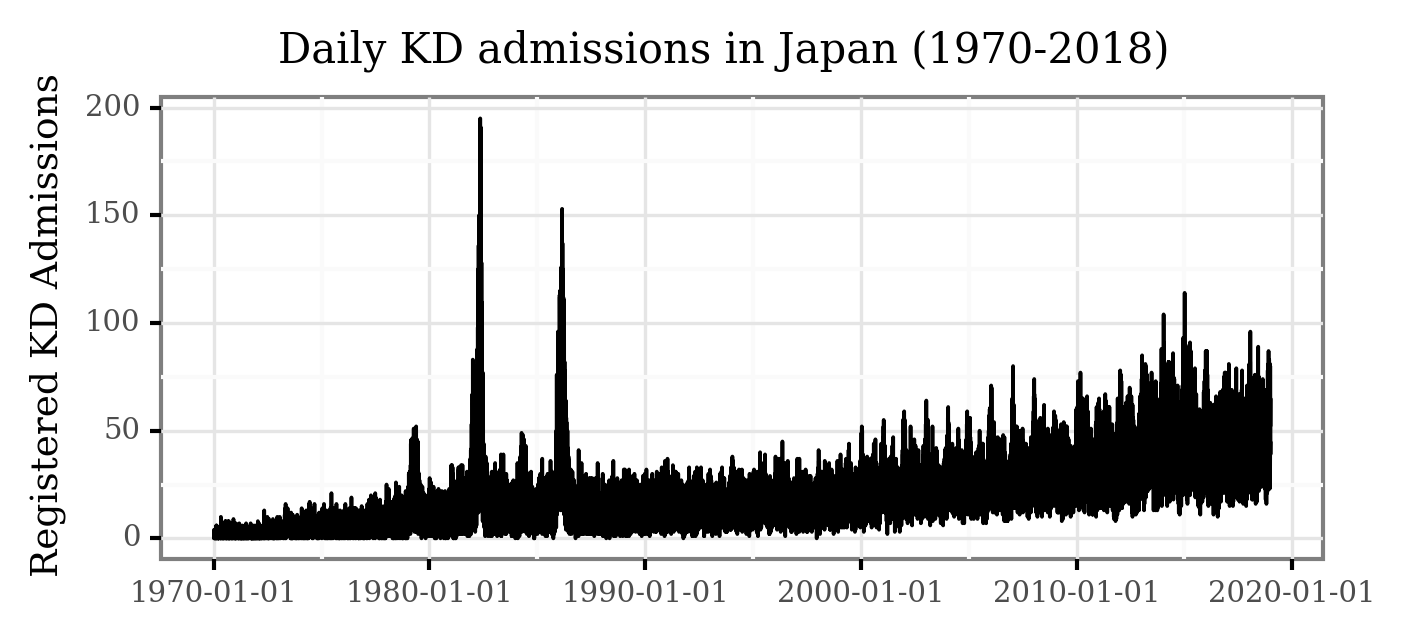

<ggplot: (8734842526082)>

In [4]:
(p9.ggplot(kd_japan)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line()
 + p9.labs(x='', y='Registered KD Admissions', title='Daily KD admissions in Japan (1970-2018)')
 + p9.theme(figure_size=(5, 2),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)


While some of the patterns are visible here, the daily variance makes some of the temporal features hard to visualize. Let's generate the monthly averages of daily admissions and plot the figure again:

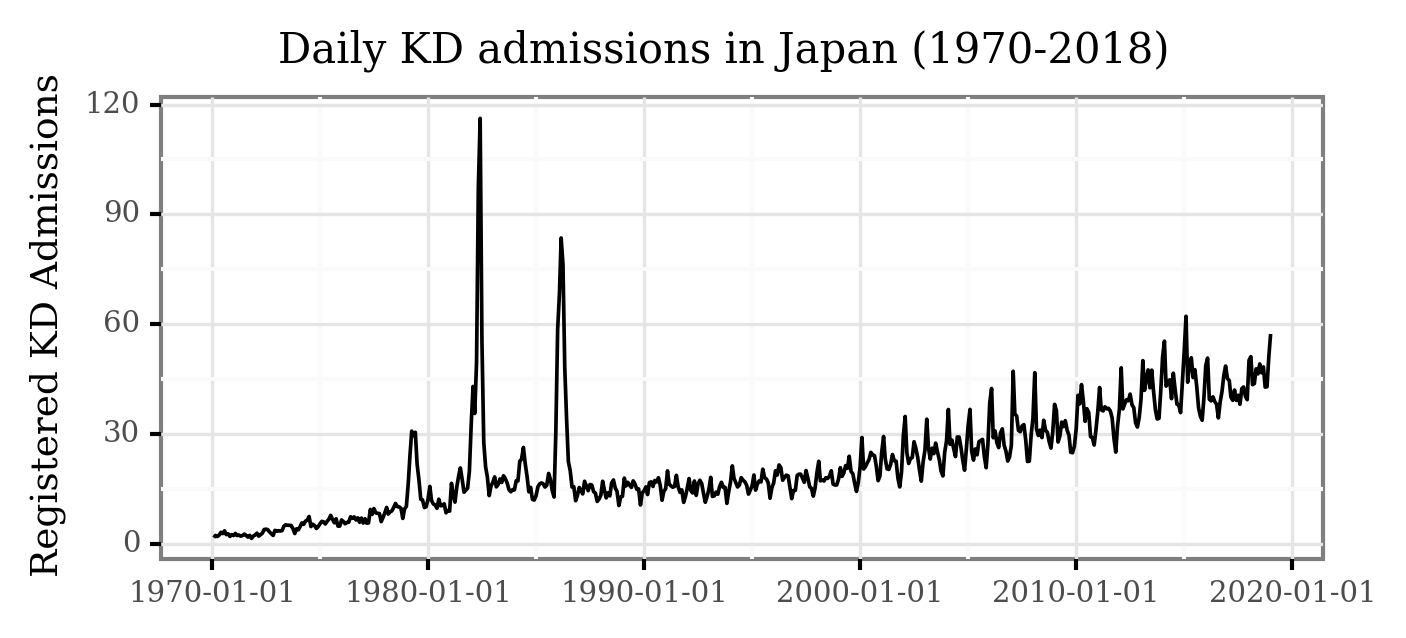

<ggplot: (8734842452011)>

In [5]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
                + p9.aes('date', 'kd_cases')
                + p9.geom_line()
                + p9.labs(x='', y='Registered KD Admissions',
                        title='Daily KD admissions in Japan (1970-2018)')
                + p9.theme(figure_size=(5, 2),
                                dpi=300,
                                title=p9.element_text(size=10),
                                axis_title_y=p9.element_text(size=9))
)
)

 


Notice how now, 3 features are clearly visible:

+ The three _epidemic_ events during 1979, 1982 and 1986.
+ The increasing trend from 2000 on.
+ The marked periodicity (yearly seasonality) from 2000 on.

Taking a closer look to the pre-1990 period:

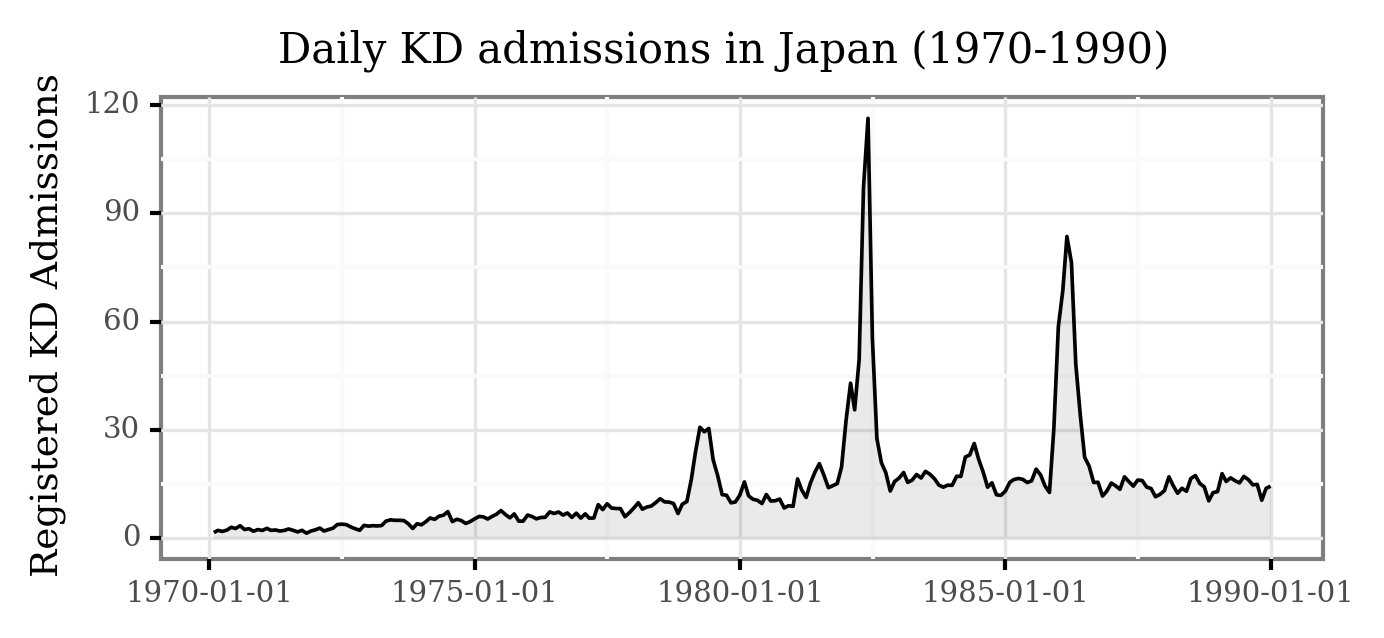

<ggplot: (8734842397356)>

In [6]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .loc[:'1990-01-01']
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line()
 + p9.geom_area(alpha=.1)
 + p9.labs(x='', y='Registered KD Admissions',
           title='Daily KD admissions in Japan (1970-1990)')
 + p9.theme(figure_size=(5, 2),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)
)

The epidemic events are now even more clear!


Let's look closely to the post 2000 era:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


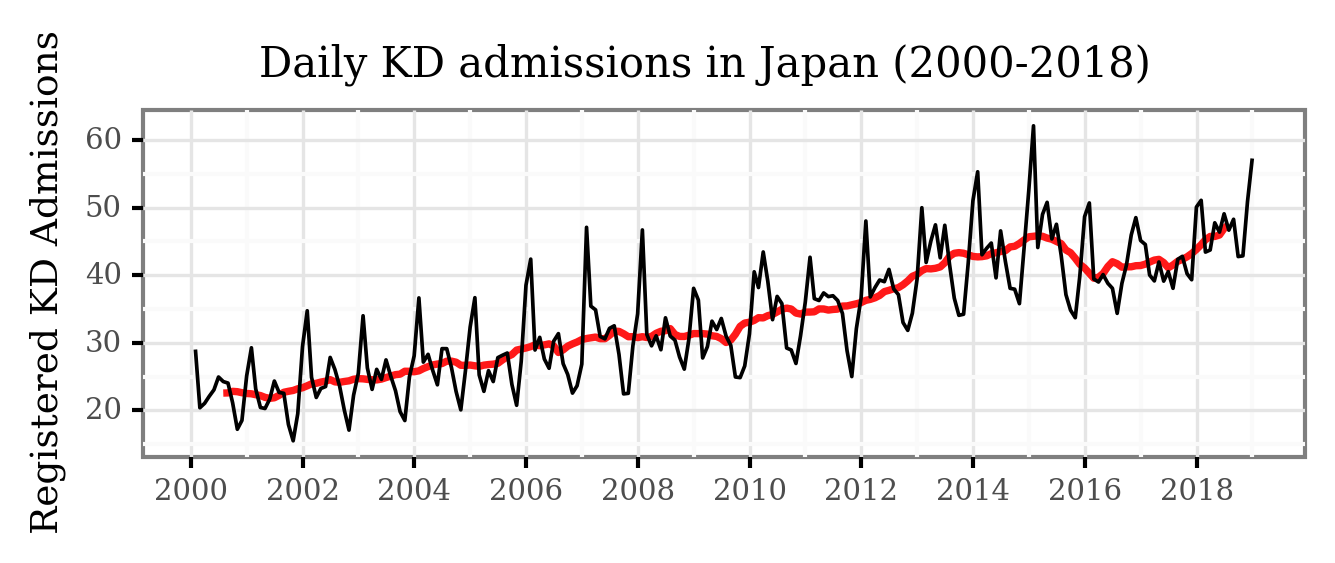

<ggplot: (8734842423477)>

In [7]:
(kd_japan
 .set_index('date')
 .resample('M')
 .mean()
 .loc['2000-01-01':]
 .reset_index()
 .pipe(lambda dd: p9.ggplot(dd)
 + p9.aes('date', 'kd_cases')
 + p9.geom_line(p9.aes(y='kd_cases.rolling(12, center=True).mean()'),
                 color='red', size=1, alpha=.9)
 + p9.geom_line()
 + p9.scale_x_datetime(labels=date_format('%Y'))
 + p9.labs(x='', y='Registered KD Admissions',
           title='Daily KD admissions in Japan (2000-2018)')
 + p9.theme(figure_size=(5, 1.5),
                  dpi=300,
                  title=p9.element_text(size=10),
                  axis_title_y=p9.element_text(size=9))
)
)

Both the yearly seasonality and the trend become clear now! 

There is a yearly cycle which peaks every winter and has its nadir during the fall, and the trend, represented by the red line (displaying the 12-month moving average), shows a change from ~23 daily cases in the early 2000s to about ~45 daily cases in 2016.

We are undergoing more formal time series analysis work, but for the sake of this example let's keep it here.

The period from 2016 to 2018 seems to break both the seasonal and trend pattern, and the reasons for these are being studied, but let's now focus on the data for Tokyo used in this study.

#### Tokyo records (2011-2018)

We have another dataset with the reported dates of onset for a total of 13790 cases diagnosed in hospitals within the prefecture of Tokyo from 2011 to 2018.

Let's load the already pre-processed file:

In [3]:
kd_tokyo = pd.read_csv('../data/kawasaki_disease/tokyo_ts.csv')

And visualize the full temporal series:

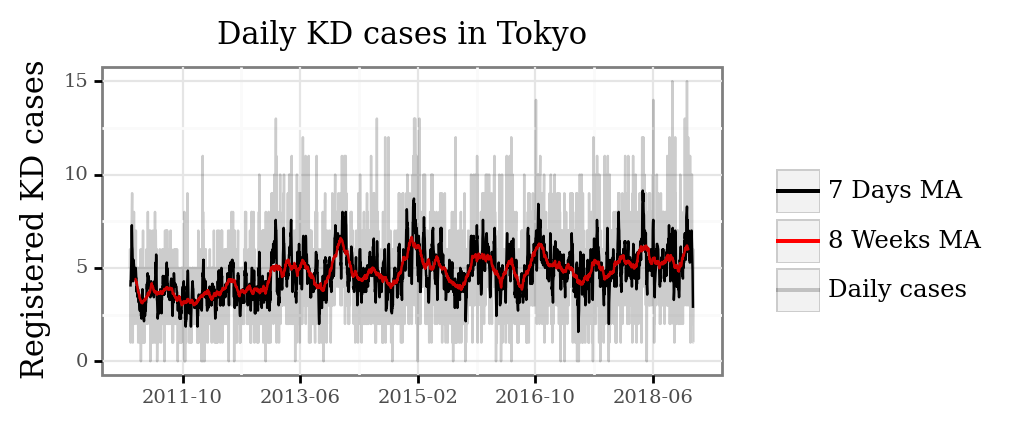

<ggplot: (8734842399202)>

In [9]:
(kd_tokyo
 .assign(rolling_7=lambda dd: dd.cases.rolling(7, center=True).mean())
 .assign(rolling_56=lambda dd: dd.cases.rolling(7 * 8, center=True).mean())
 .rename(columns={'cases': 'Daily cases', 'rolling_7': '7 Days MA', 'rolling_56': '8 Weeks MA'})
 .melt(['date', 'year'])
 .dropna()
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('date', 'value', color='variable', group='variable') 
        + p9.geom_line(p9.aes(alpha='variable'))
        + p9.scale_alpha_manual([1, 1, .2])
        + p9.scale_color_manual(['black', 'red', 'black'])
       + p9.scale_x_datetime(labels=date_format('%Y-%m'), breaks=date_breaks('20 months'))
       + p9.theme(figure_size=(4, 2), title=p9.element_text(size=11))
       + p9.labs(x='', y='Registered KD cases', title='Daily KD cases in Tokyo', color='',
                 alpha='')
)
)

We can see how for the _smaller_ sample of Tokyo, the temporal patterns become more diffuse, with the daily cases ranging from 0 to 15. As we average over longer periods of time, periods with a consistent increased number of daily cases become more apparent.

For this study, we decided to generate weekly data and select the **top 5** weeks and **bottom 5** weeks with regards to the average number of daily KD cases.

We will now convert the daily data to weekly average of daily cases for all the consecutive weeks in the year (since the last week of the year doesn't have 7 full days, this should make them still comparable).

As the data was based on admissions up to 31st of December 2018 and the lag from reported onset to actual admission ranges from 2 to 5 days, we removed the data from after the 24th of December 2018 since the data for that last week couldn't be considered _complete_.

Let's process the data:

In [4]:
kd_weekly_tokyo = (kd_tokyo
        .assign(date=lambda dd: pd.to_datetime(dd.date))
        .assign(week=lambda dd: (((dd.date.dt.dayofyear - 1) // 7) + 1).clip(None, 52))
        .groupby(['year', 'week'], as_index=False)
        .cases.mean()
)

We can now visualize the average number of daily cases per week:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


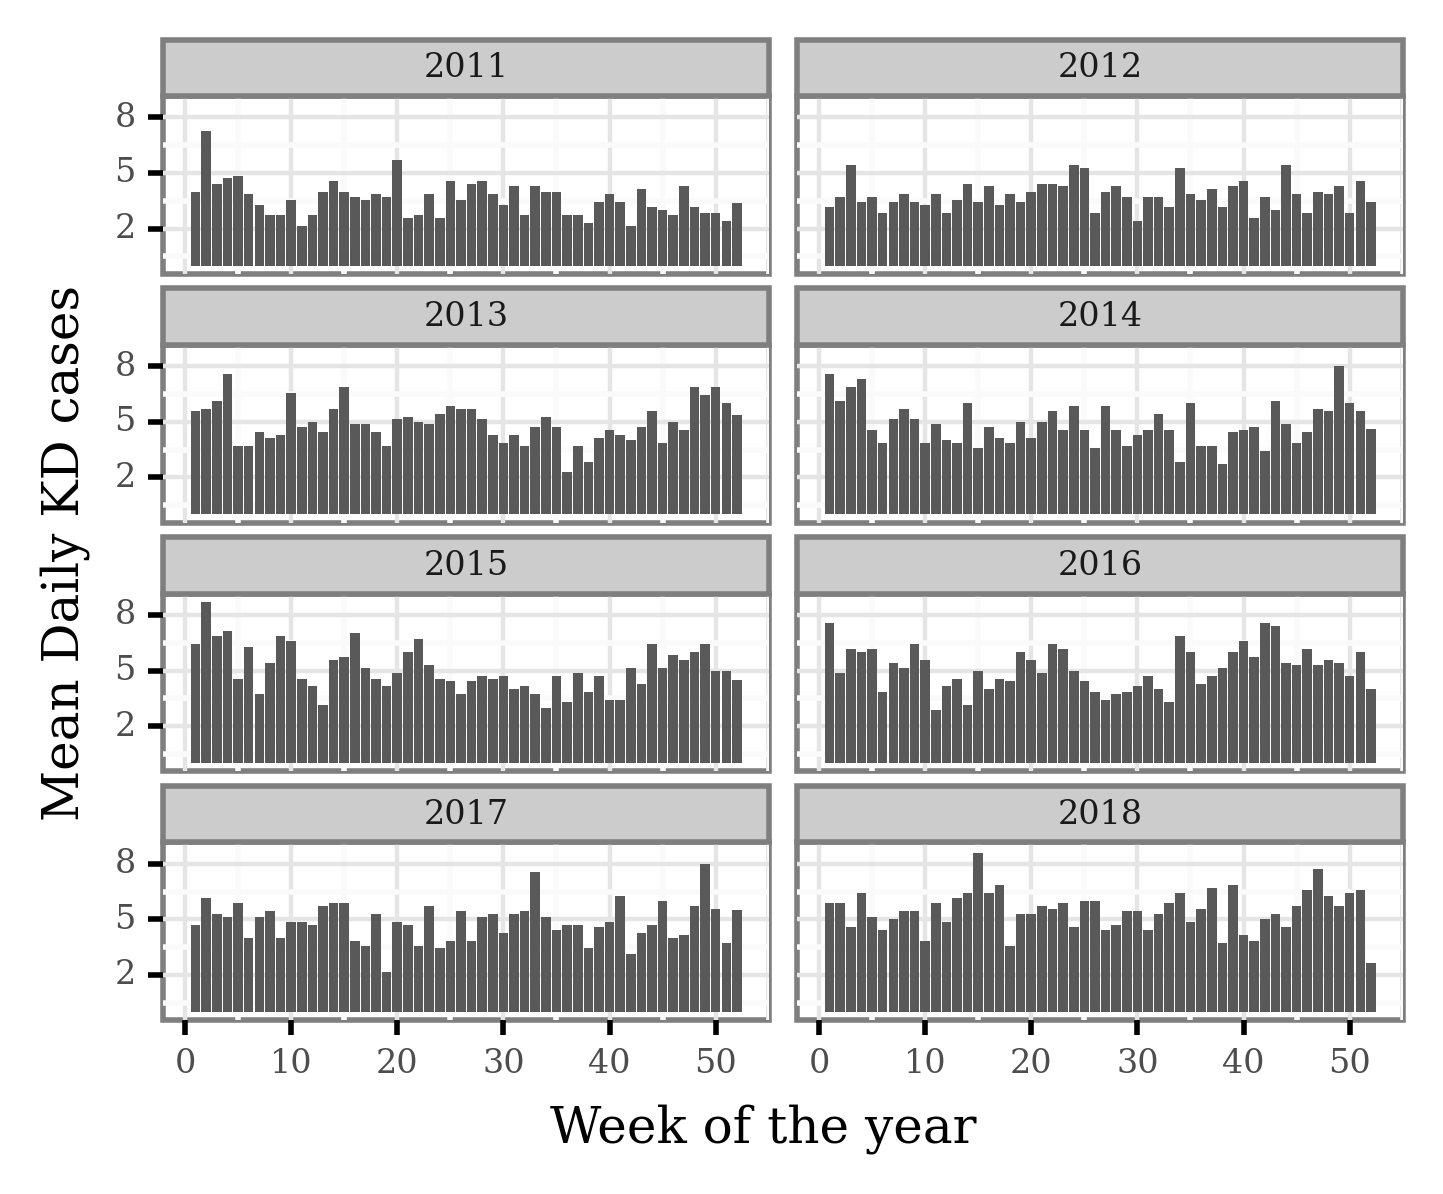

<ggplot: (8734842320887)>

In [11]:
(kd_weekly_tokyo
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('week', 'cases') 
                + p9.geom_col()
                + p9.theme(figure_size=(4, 3), dpi=400, strip_text=p9.element_text(size=6),
                           axis_text=p9.element_text(size=6), subplots_adjust={'hspace': .4},
                           legend_key_size=7, legend_text=p9.element_text(size=7))
                + p9.facet_wrap('year', ncol=2)
                + p9.scale_y_continuous(breaks=[2, 5, 8])
                + p9.scale_fill_manual(['#B2182B', '#2166AC'])
                + p9.labs(x='Week of the year', y='Mean Daily KD cases', fill='', 
                          title='')
                )
)

Let's now select the weeks associated to the yearly KD maxima and minima:

In [5]:
kd_weekly_tokyo_minmax = (kd_weekly_tokyo
 .groupby(['year'])
 .apply(lambda dd: pd.concat([dd.sort_values('cases').iloc[:5].assign(label='KD Minima'),
                              dd.sort_values('cases').iloc[-5:].assign(label='KD Maxima')]))
 .reset_index(drop=True)
)

If we now mark the weeks associated to KD Maxima and Minima:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


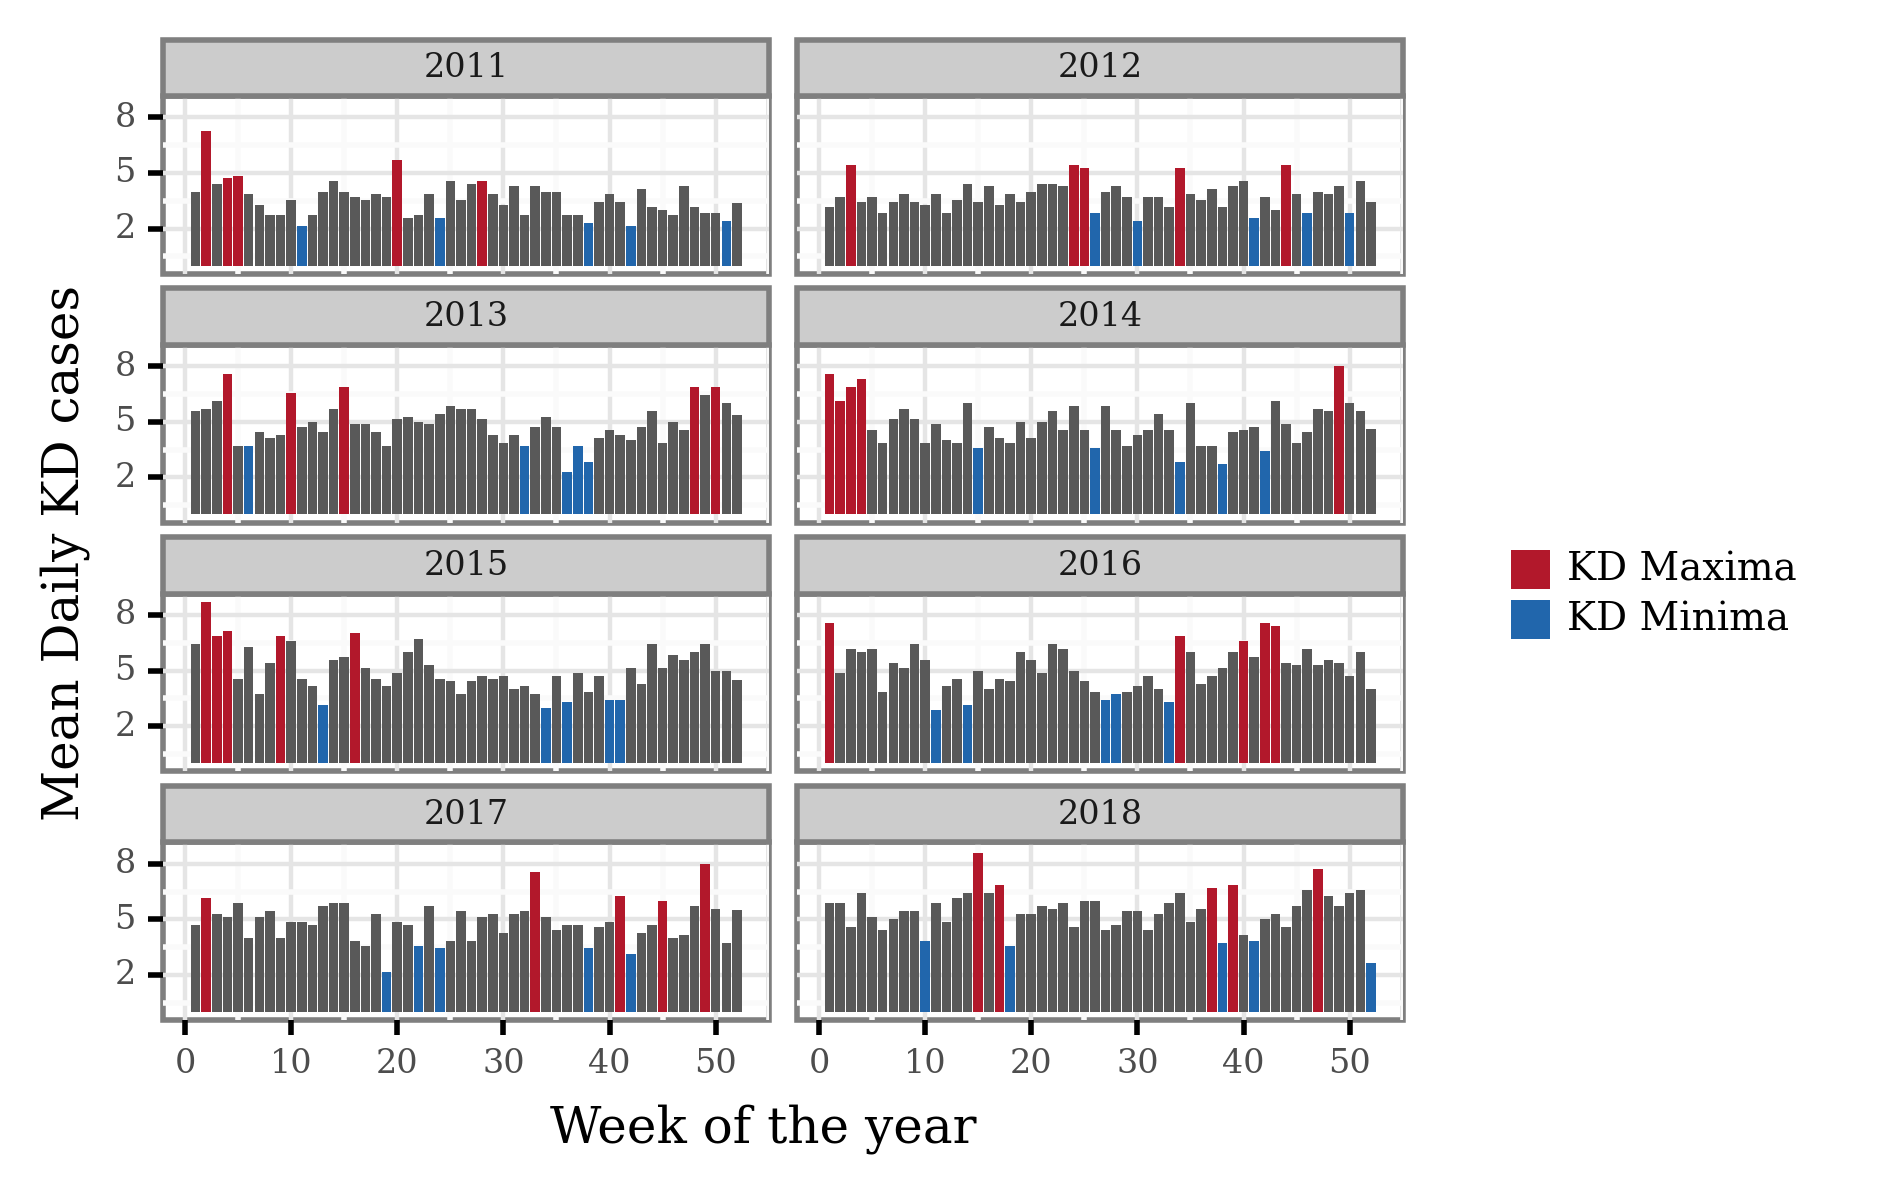

<ggplot: (8734836946565)>

In [13]:
(kd_weekly_tokyo
 .pipe(lambda dd: p9.ggplot(dd) 
                + p9.aes('week', 'cases') 
                + p9.geom_col()
                + p9.geom_col(p9.aes(fill='label'), data=kd_weekly_tokyo_minmax)
                + p9.theme(figure_size=(4, 3), dpi=400, strip_text=p9.element_text(size=6),
                           axis_text=p9.element_text(size=6), subplots_adjust={'hspace': .4},
                           legend_key_size=7, legend_text=p9.element_text(size=7))
                + p9.facet_wrap('year', ncol=2)
                + p9.scale_y_continuous(breaks=[2, 5, 8])
                + p9.scale_fill_manual(['#B2182B', '#2166AC'])
                + p9.labs(x='Week of the year', y='Mean Daily KD cases', fill='', 
                          title='')
                )
)

We can now generate a list of single dates that we'll later use to select the trajectories associated to either KD maxima or minima. This list will be shared so as to enable the reproduction of the differential trajectory analysis.

In [6]:
min_max_weekly_dates = (kd_weekly_tokyo_minmax
 .merge((pd.DataFrame(dict(date=pd.date_range('2011', '2018-12-31')))
         .assign(year=lambda dd: dd.date.dt.year)
         .assign(week=lambda dd: (((dd.date.dt.dayofyear - 1) // 7) + 1)
         .clip(None, 52))))
 .drop(columns='cases')
)

In [15]:
min_max_weekly_dates.to_csv('../data/kawasaki_disease/kd_min_max_dates.csv', index=False)

If you want to reproduce the analysis, just read the data running the following cell, and you should be able to follow the next steps.

In [16]:
min_max_weekly_dates = pd.read_csv('../data/kawasaki_disease/kd_min_max_dates.csv')

### Shapes

In [7]:
world = gpd.read_file('../data/shapes/ne_50m_admin_0_countries.zip')

## Generating the backtrajectories

We will generate the backtrajectories using the `pysplit` library, which allows us to programmatically call HYSPLIT and generate many trajectories in bulk. For that, however, we need to have (1) a running version of HYSPLIT installed in our local machine, and (2) ARL compatible meteorology files for the period of time we want to run the trajectories. 

    

In this case, we downloaded the GDAS1 meteorology files from the ARL FTP server. These can be accessed through the following link: [ftp://arlftp.arlhq.noaa.gov/archives/gdas1/ ](ftp://arlftp.arlhq.noaa.gov/archives/gdas1/)

I am going to define here the local folders where my installation of HYSPLIT is located and where the meteorology files are.

In [8]:
HYSPLIT_DIR = '/home/afontal/utils/hysplit/exec/hyts_std'
HYSPLIT_WORKING = '/home/afontal/utils/hysplit/working'
METEO_DIR = '/home/afontal/utils/hysplit/meteo/gdas1'
OUT_DIR = '/home/afontal/projects/vasculitis2022-conference/output/trajectories'

We will now call the `generate_bulktraj` function from the `pysplit` package to generate the trajectories. In previous trials I realized that trying to call too many trajectories at once causes the call to freeze (at least in my local machine) so I ended up splitting the call by months:

In [ ]:
for year, month in product(range(2011, 2019), range(1, 13)):
    pysplit.generate_bulktraj('tokyo',
                              hysplit_working=HYSPLIT_WORKING,
                              hysplit=HYSPLIT_DIR,
                              output_dir=OUT_DIR,
                              meteo_dir=METEO_DIR,
                              years=[year],
                              months=[month],
                              meteoyr_2digits=True,
                              hours=[0, 6, 12, 18],
                              altitudes=[10],
                              coordinates=(35.68, 139.65),
                              run=-96,
                              meteo_bookends=([4, 5], [])

    )

The generated trajectories are now in the `output/trajectories` directory.

## Trajectories groupying and analysis


HYSPLIT generates a file for each of the calculated trajectories. Taking a peek at one of them we can see how they're basically tabular data giving a x-y-z coordinate and pressure level for every hour the backtrajectory lasts: in our case, a total of 96 points.

Just showing the first 24 here:

In [58]:
!sed -n '12,36p' < ../output/trajectories/tokyoapr0010spring2011040100 

     1     1    11     4     1     0     0     0     0.0   35.680  139.650     10.0    999.3
     1     1    11     3    31    23     0     1    -1.0   35.692  139.664      9.9    999.2
     1     1    11     3    31    22     0     2    -2.0   35.718  139.660     10.3    997.9
     1     1    11     3    31    21     0     3    -3.0   35.755  139.636     11.4    995.0
     1     1    11     3    31    20     0     2    -4.0   35.794  139.596     14.0    991.4
     1     1    11     3    31    19     0     1    -5.0   35.829  139.548     20.0    986.8
     1     1    11     3    31    18     0     0    -6.0   35.859  139.492     33.8    981.0
     1     1    11     3    31    17     0     1    -7.0   35.895  139.420     61.3    973.2
     1     1    11     3    31    16     0     2    -8.0   35.949  139.319    122.7    959.1
     1     1    11     3    31    15     0     3    -9.0   36.035  139.171    276.3    932.3
     1     1    11     3    31    14     0     2   -10.0   36.180  138

With `pysplit`, we can directly load all trajectory files into a single object, or 'trajectory group'. Let's do that:

In [9]:
all_trajs = pysplit.make_trajectorygroup(glob('../output/trajectories/*'))

Since I want to manipulate these myself, we can extract the data of every single trajectory into a pandas DataFrame:

In [59]:
all_trajectories_data = (pd.concat([t.data.assign(traj_id=i) for i, t in enumerate(all_trajs)])
                         .drop(columns=['Temperature_C',  'Temperature', 'Mixing_Depth'])
                         .assign(start_time=lambda dd: dd.DateTime - pd.to_timedelta(dd.Timestep, unit='h'))
)

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


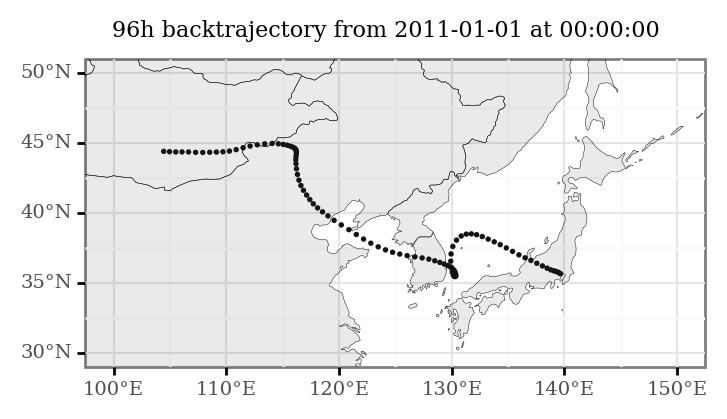

<ggplot: (8774956111653)>

In [79]:
(all_trajectories_data
 .loc[lambda dd: dd.start_time=='2011-01-01 00:00:00']
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(size=.1)
       + p9.geom_map(world, alpha=.1, size=.1)
       + p9.theme(figure_size=(4, 2), title=p9.element_text(size=8))
       + p9.labs(title='96h backtrajectory from 2011-01-01 at 00:00:00')
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(100, 150))
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 50)))
)

What we want, however, is to have these trajectories as continuous _lines_, so we will linearly interpolate the 96 points of each trajectory to generate _trajectory lines_.

In [73]:
trajectory_lines = (all_trajectories_data
                    .groupby(['traj_id', 'start_time'], as_index=False)
                    ['geometry']
                    .apply(lambda x: LineString([(i.x, i.y) for i in x.to_list()]))
)

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


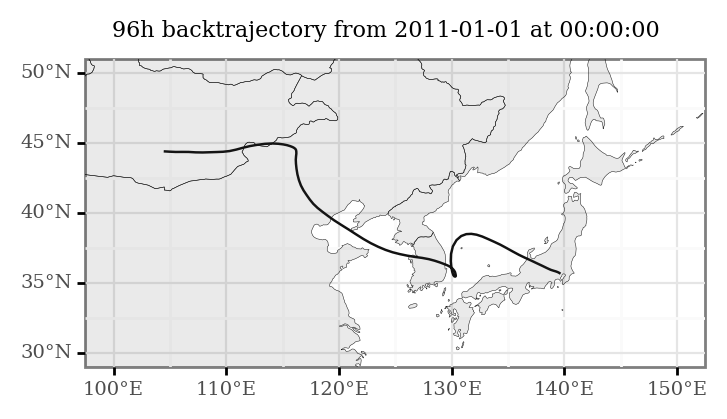

<ggplot: (8774984786219)>

In [80]:
(trajectory_lines
 .loc[lambda dd: dd.start_time=='2011-01-01 00:00:00']
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map()
       + p9.geom_map(world, alpha=.1, size=.1)
       + p9.theme(figure_size=(4, 2), title=p9.element_text(size=8))
       + p9.labs(title='96h backtrajectory from 2011-01-01 at 00:00:00')
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(100, 150))
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 50)))
)

If we want to generate an animation with several of these computed trajectories:

In [36]:
plots = []
for s, t in trajectory_lines.loc[lambda dd: dd.start_time < '2011-01-15'].groupby('start_time'):
    p = (t
        .pipe(lambda dd: p9.ggplot(dd)
                + p9.geom_map()
                + p9.geom_map(world, alpha=.1, size=.1)
                + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 180))
                + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(10, 65))
                + p9.annotate(geom='text', label=s, x=164, y=10, size=8)
                + p9.labs(x='', y='', title='96h backtrajectory from Tokyo')
                + p9.theme(title=p9.element_text(size=10), dpi=200))
        )
    plots.append(p)

ani = PlotnineAnimation(plots, interval=500, repeat_delay=500)
ani.save('../output/animation.gif')
ani

Now, we will generate a grid so that we can generate counts of the number of times each area in the map is intersected in various conditions so that we can test for differential areas.

In [11]:
margin = 1
xmin, ymin, xmax, ymax = all_trajectories_data.total_bounds.round() + [200, -margin, 0, margin]
n_cells = 200
cell_size = (xmax - xmin) / n_cells
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid = (gpd.GeoDataFrame(grid_cells, columns=['geometry'])
        .assign(cell=lambda dd: dd.geometry)
        .assign(x=lambda dd: dd.cell.centroid.x, y=lambda dd: dd.cell.centroid.y)
)

x_y_poly = grid[['x', 'y', 'cell']].drop_duplicates()

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

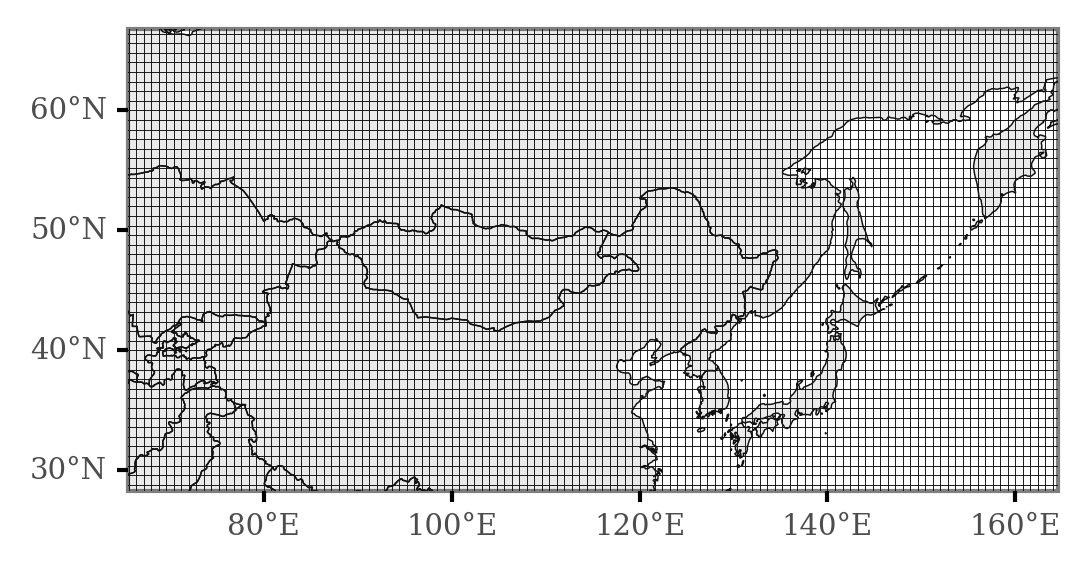

<ggplot: (8752495030507)>

In [22]:
(p9.ggplot(grid) 
     + p9.geom_map(world, alpha=.1, size=.2)
     + p9.geom_map(fill=None, size=.1)               
     + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(70, 160))
     + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(30, 65))
     + p9.theme(figure_size=(4, 2), dpi=300, panel_grid=p9.element_blank())
)

We can now merge the trajectories to include only those contained in the dates which we previously assigned to days of KD minima and maxima:

In [87]:
min_max_trajectories = (trajectory_lines
                         .assign(date=lambda dd: pd.to_datetime(dd.start_time.dt.date))
                         .merge(min_max_weekly_dates))

And then, we perform a merge operation with the `geopandas` `sjoin` function, specifying the `op` parameter as 'intersects' so that we can get a count of intersections per category.

In [88]:
grid_intersections = gpd.sjoin(min_max_trajectories, grid, op='intersects')

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


We can now visualize the average trajectory path per year and KD maxima/minima:

In [94]:
def negative_log(x):
    return np.sign(x) * np.log10(np.abs(x))

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longe

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

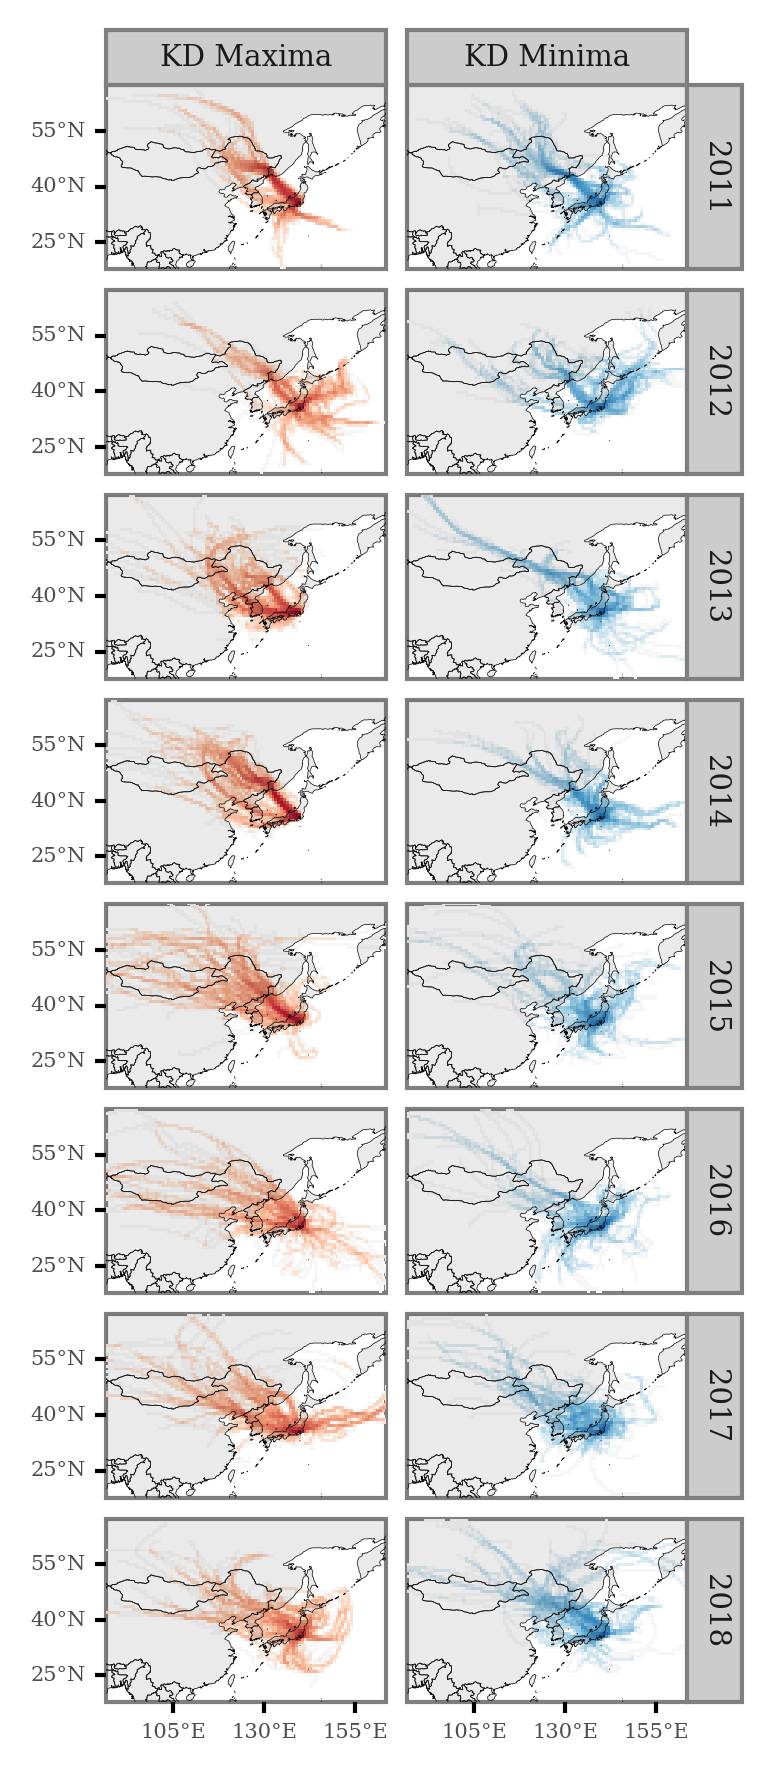

<ggplot: (8774987244954)>

In [95]:
(grid_intersections
 .groupby(['x', 'y', 'label', 'year'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly)
 .assign(n=lambda dd: np.where(dd.label=='KD Minima', -dd.n, dd.n))
 .assign(n=lambda dd: negative_log(dd.n))
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='n', geometry='cell'), size=0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.facet_grid(['year', 'label'])
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), figure_size=(2.5, 7),
                  axis_text=p9.element_text(size=5), strip_text=p9.element_text(size=7))
       + p9.labs(fill='')
       + p9.scale_fill_continuous('RdBu_r')
       + p9.scale_alpha_continuous(trans='sqrt')
       + p9.guides(fill=False, alpha=False)
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 160), breaks=[105, 130, 155])
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 65), breaks=[25, 40, 55]))
)

We can generate the same plot for the full period:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longe

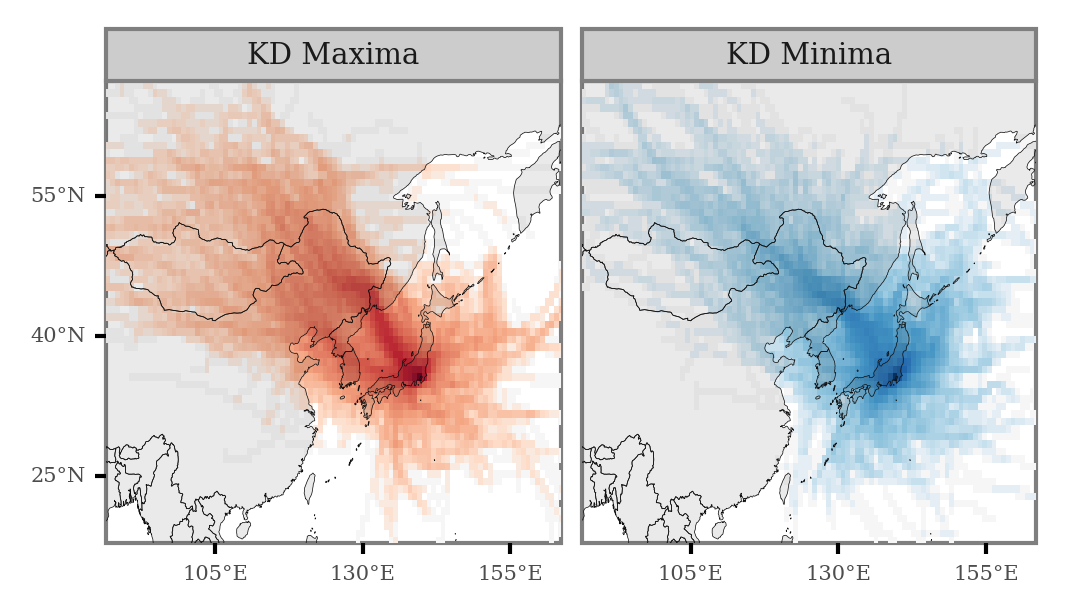

<ggplot: (8774954279211)>

In [98]:
(grid_intersections
 .groupby(['x', 'y', 'label'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly)
 .assign(n=lambda dd: np.where(dd.label=='KD Minima', -dd.n, dd.n))
 .assign(n=lambda dd: negative_log(dd.n))
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='n', geometry='cell'), size=0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.facet_wrap(['label'], ncol=2)
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), figure_size=(4, 2),
                  axis_text=p9.element_text(size=5), strip_text=p9.element_text(size=7))
       + p9.labs(fill='')
       + p9.scale_fill_continuous('RdBu_r')
       + p9.scale_alpha_continuous(trans='sqrt')
       + p9.guides(fill=False, alpha=False)
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 160), breaks=[105, 130, 155])
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 65), breaks=[25, 40, 55]))
)

And if we now calculate the Log2 Fold Change of the number of counts for every cell, keeping only those cells which are intersected by more than 11 trajectories (over 0.5% of all the trajectories), we get the differential plot:

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely

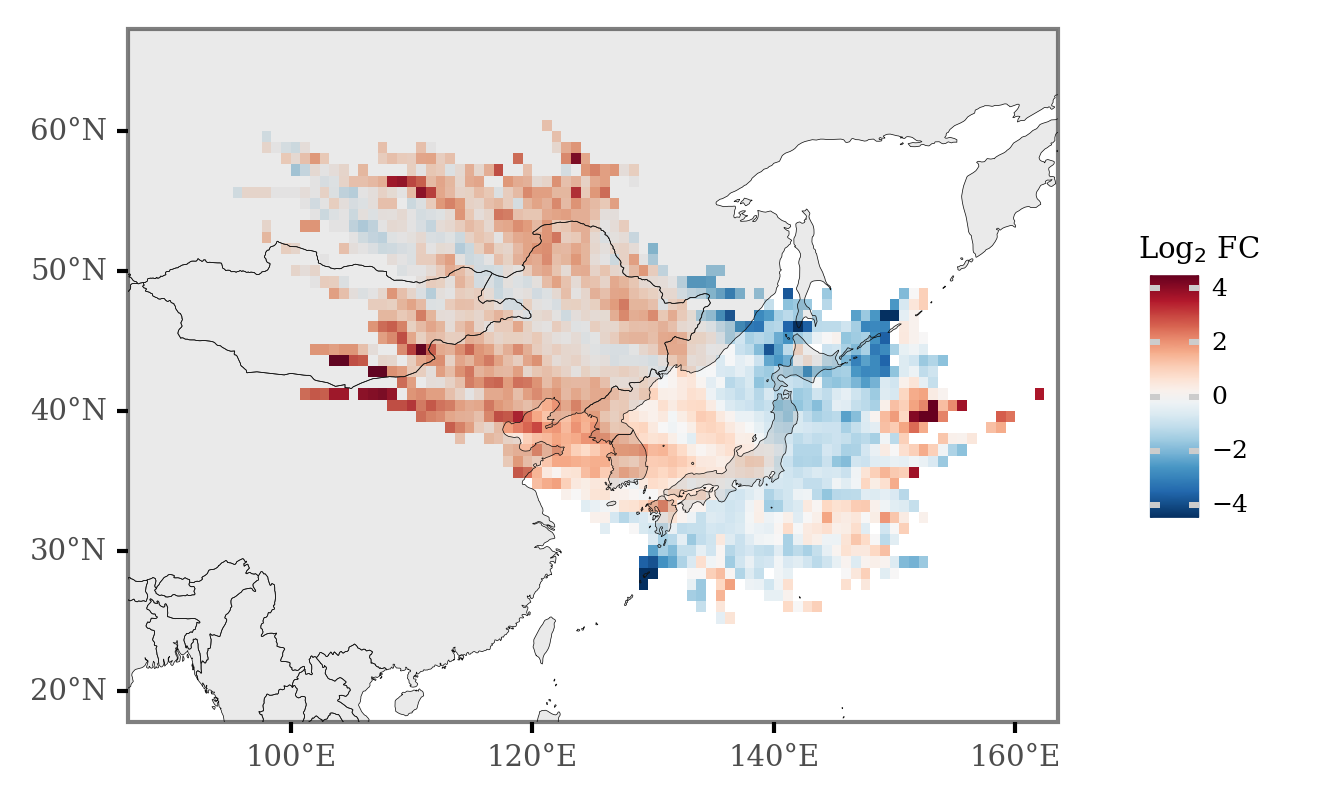

<ggplot: (8774954245928)>

In [101]:
(grid_intersections
 .groupby(['x', 'y', 'label'])
 .size()
 .rename('n')
 .reset_index()
 .pivot(['x', 'y'], 'label', 'n')
 .fillna(0)
 .assign(diff=lambda dd: dd['KD Maxima'] - dd['KD Minima'])
 .assign(fc=lambda dd: np.log2(dd['KD Maxima'] / dd['KD Minima']))
 .sort_values('diff')
 .reset_index()
 .merge(x_y_poly)
 .assign(total_n=lambda dd: dd['KD Maxima'] + dd['KD Minima'])
 .loc[lambda dd: dd.total_n >= 1120 * 0.01]
#  .loc[lambda dd: np.isfinite(dd.fc)]
#  .sort_values('fc')
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.geom_map(p9.aes(fill='fc', geometry='cell'), size=.0)
       + p9.geom_map(data=world, size=.1, alpha=.1)
       + p9.scale_fill_continuous('RdBu_r')
       + p9.scale_alpha_continuous(trans='log10')
       + p9.theme(dpi=300, panel_grid=p9.element_blank(), plot_background=p9.element_blank(),
                  legend_background=p9.element_blank(), legend_key_size=8,
                  legend_text=p9.element_text(size=6), legend_title_align='center',
                  legend_title=p9.element_text(size=7))
       + p9.labs(fill='Log$_2$ FC')
       + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(90, 160))
       + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(20, 65)))
)

## Extra

I'll just share here some code snippets made to generate figures with average air mass sources per month / week that I showed in some of the presentations:

In [111]:
trajectories_18 = trajectory_lines.query('start_time.dt.year==2018')

In [120]:
trajectories_18_intersections = (gpd.sjoin(trajectories_18, grid, op='intersects')
                                  .assign(date=lambda dd: pd.to_datetime(dd.start_time.dt.date))
                                  .pipe(add_date_columns)
                                )

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longe

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

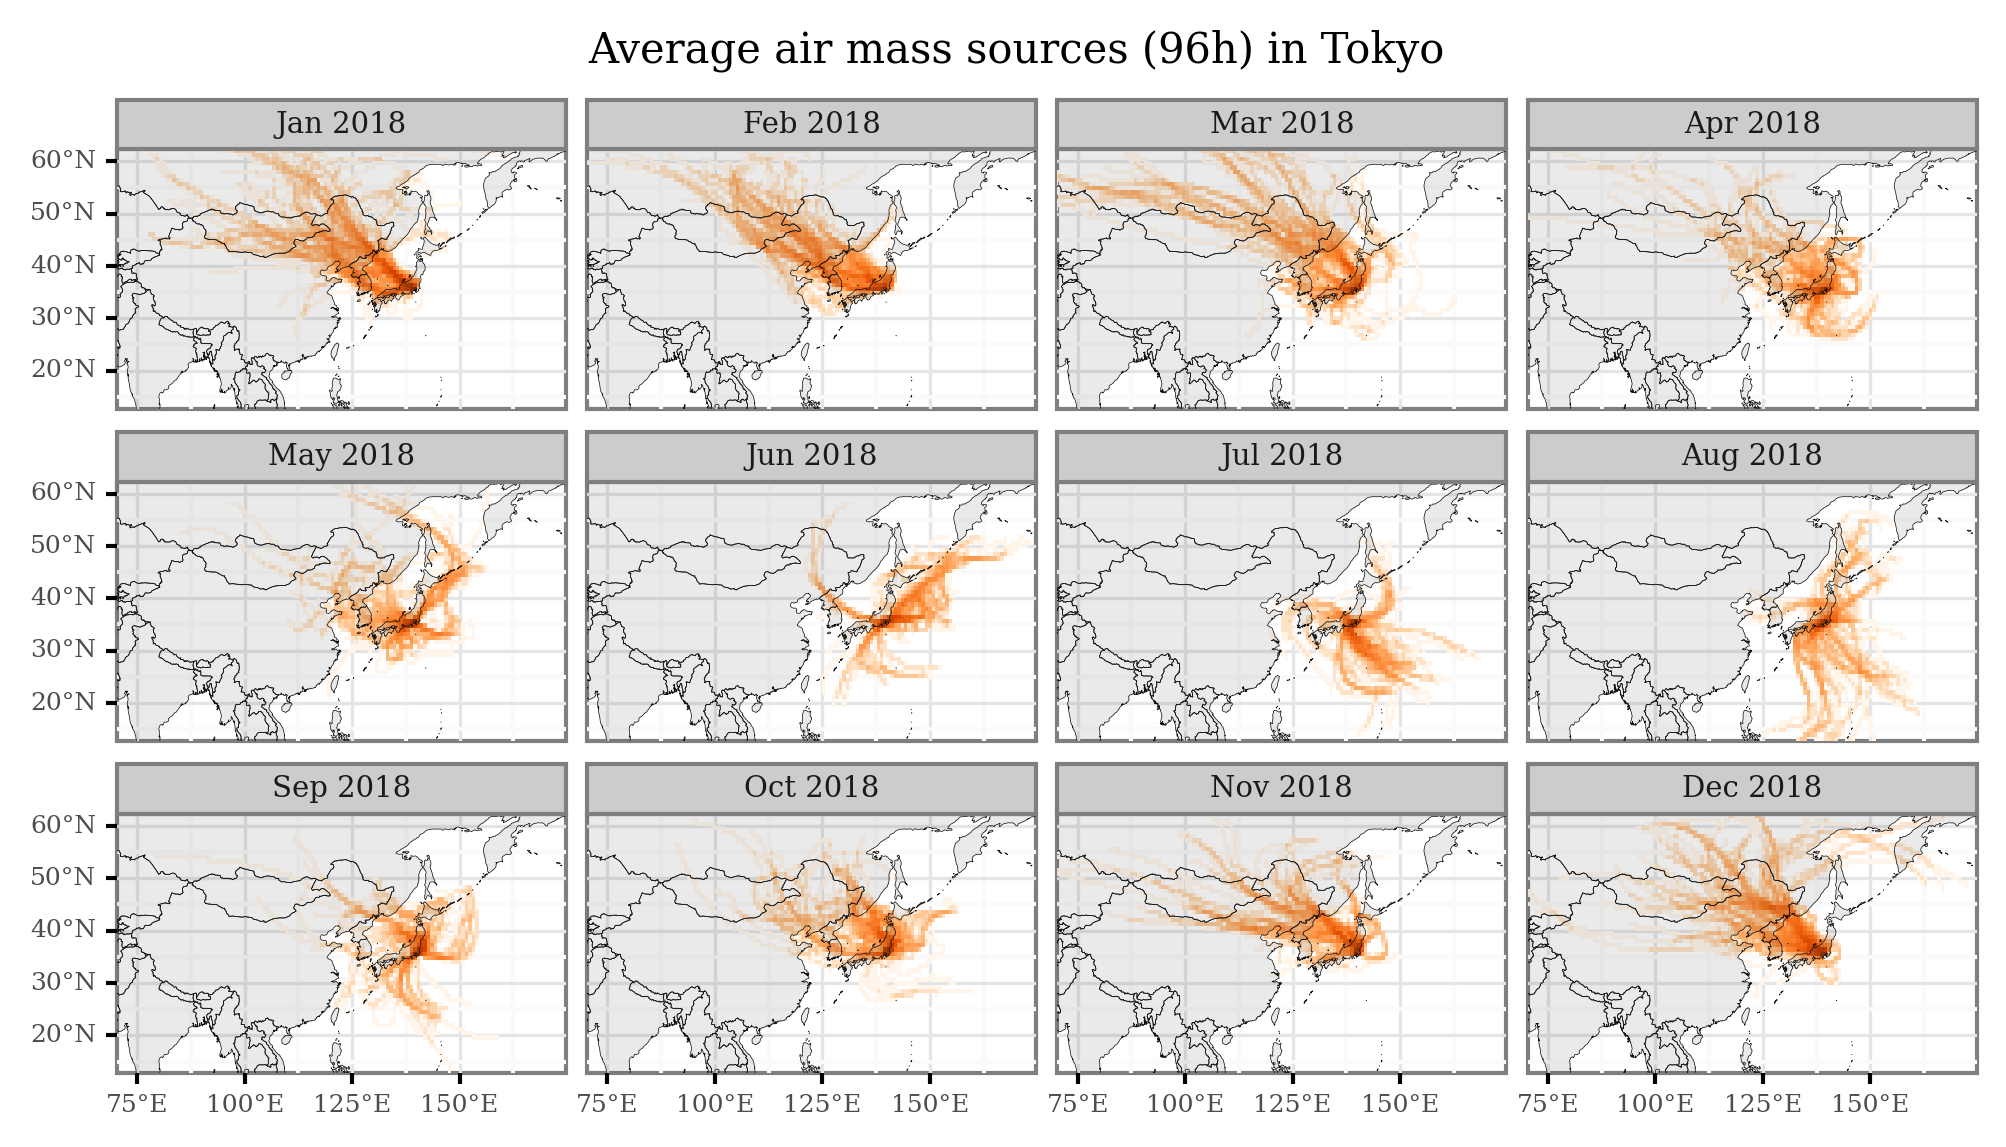

<ggplot: (8774950369431)>

In [122]:
(trajectories_18_intersections
 .groupby(['x', 'y', 'month_name'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly, on=['x', 'y'])
 .rename(columns={'cell': 'geometry'})
 .loc[lambda dd: dd['n'] > 0]
 .pipe(lambda dd: p9.ggplot(dd)
  + p9.geom_map(p9.aes(fill='n'), color=None, alpha=1)
  + p9.geom_map(world, alpha=.1, size=.1)
  + p9.scale_fill_continuous('Oranges', trans='log10')
  + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(75, 170))
  + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 60))
  + p9.facet_wrap('month_name', ncol=4, labeller=lambda x: x + ' 2018')
  + p9.guides(fill=False)
  + p9.ggtitle('Average air mass sources (96h) in Tokyo')
  + p9.theme(figure_size=(8, 4),
             axis_text=p9.element_text(size=6),
             title=p9.element_text(size=10),
             dpi=300,
             strip_text=p9.element_text(size=7))
  )
)

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longe

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/afontal/.cache/pypoetry/virtualenvs/vasculitis2022-conference-w24wV9dD-py3.8/lib/python3.8/site-p

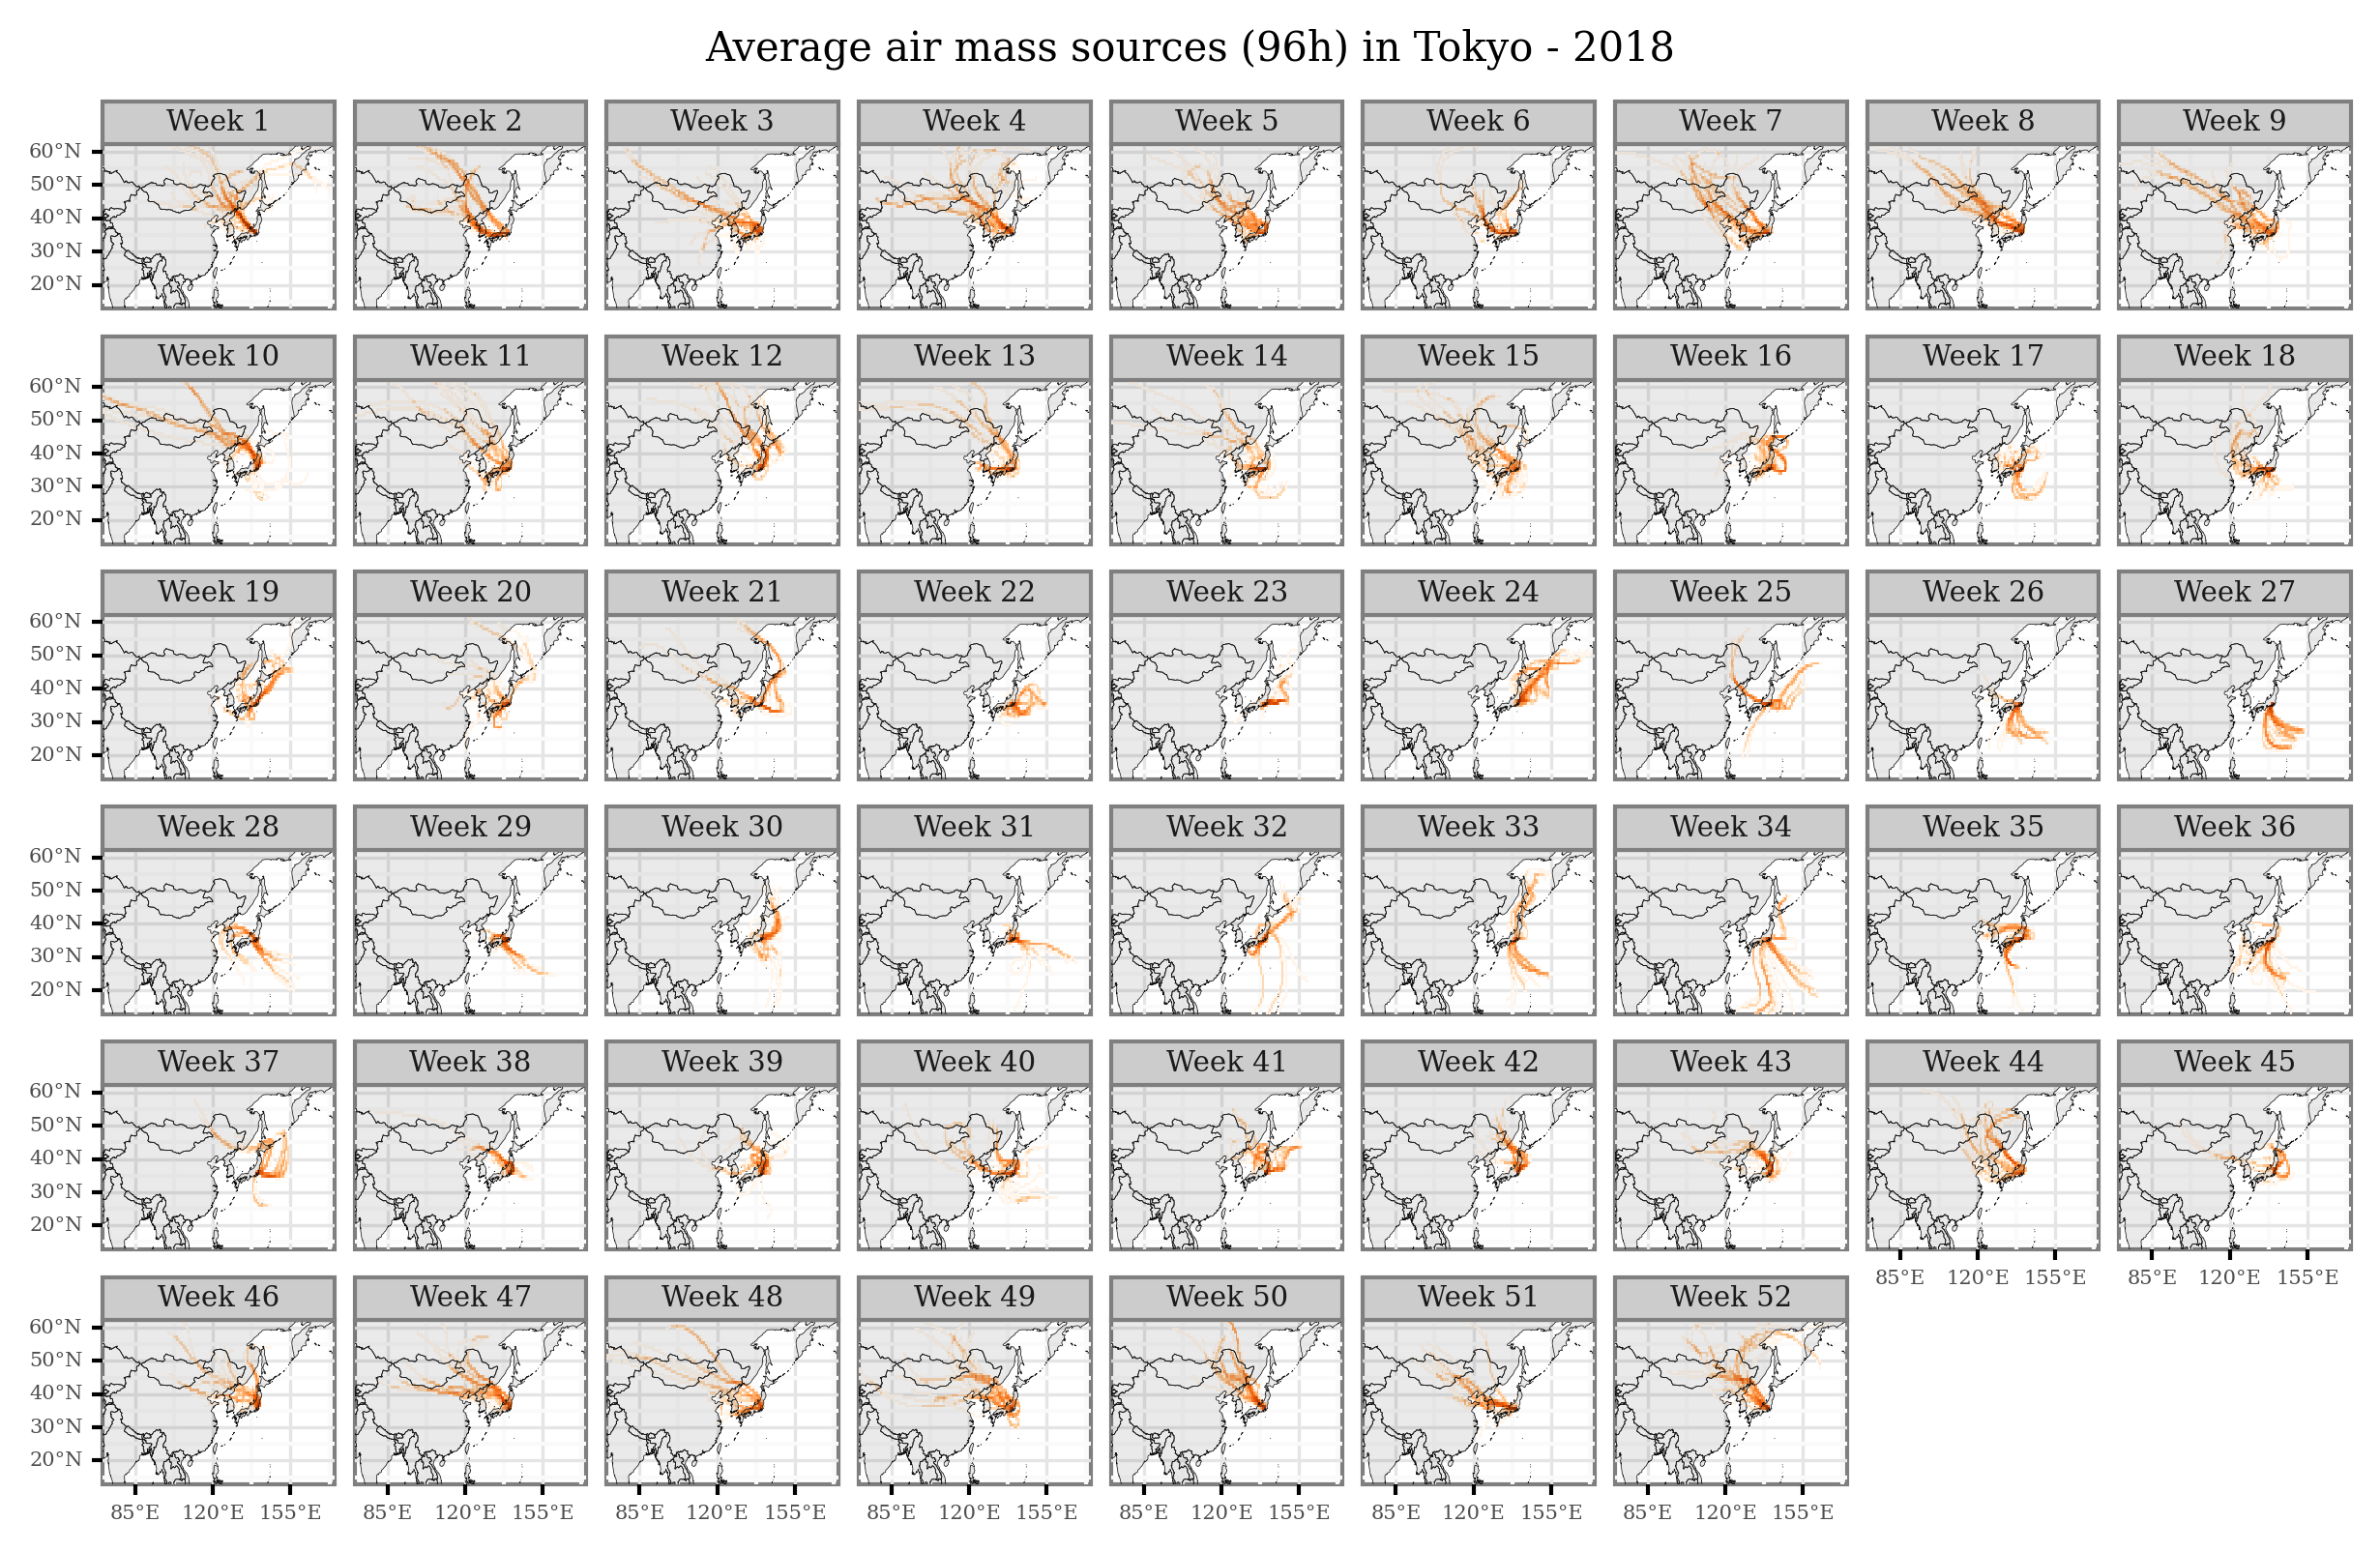

<ggplot: (8774989728961)>

In [123]:
(trajectories_18_intersections
  .groupby(['x', 'y', 'week'])
 .size()
 .rename('n')
 .reset_index()
 .merge(x_y_poly, on=['x', 'y'])
 .rename(columns={'cell': 'geometry'})
 .loc[lambda dd: dd['n'] > 0]
 .pipe(lambda dd: p9.ggplot(dd)
  + p9.geom_map(p9.aes(fill='n'), color=None, alpha=1)
  + p9.geom_map(world, alpha=.1, size=.1)
  + p9.scale_fill_continuous('Oranges', trans='log10')
  + p9.scale_x_continuous(labels=custom_format('{:0g}°E'), limits=(75, 170), breaks=[85, 120, 155])
  + p9.scale_y_continuous(labels=custom_format('{:0g}°N'), limits=(15, 60))
  + p9.facet_wrap('week', ncol=9, labeller = lambda x: f'Week {x}')
  + p9.guides(fill=False)
  + p9.ggtitle('Average air mass sources (96h) in Tokyo - 2018')
  + p9.theme(figure_size=(10, 6),
             dpi=300,
             axis_text=p9.element_text(size=5),
             title=p9.element_text(size=10),
             strip_text=p9.element_text(size=7),
             strip_margin=p9.element_blank(),
             )
  )
)

## Comments

For any questions or ideas, please write a comment below using your GitHub account, or simply send an email to alejandro.fontal@isglobal.org

Thanks for reading!